In [15]:
import torch
import torchsummary
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import math
import glob
import time

In [16]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 200
BATCH_SIZE = 1

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 256, 256, 3

Device: cuda:0


In [17]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import numpy as np
import torch
import math
import os
import glob

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            # transforms.RandomAdjustSharpness(0.25),
            # transforms.RandomHorizontalFlip(0.5),
            # transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            # transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data with all of the classes
root = '..\\data\\'
data_dirs = glob.glob(root + '**/*.jpg', recursive=True)
data_dirs = np.array(data_dirs)
data_dirs = data_dirs.flatten()

roots = np.array([root] * len(data_dirs))
data_dirs = np.core.defchararray.add(roots, data_dirs)

# Get the indices for the train/val/test split of 75/15/15
train_split = math.floor(1 * len(data_dirs))
val_split = math.ceil(0.00 * len(data_dirs))
test_split = val_split * 0

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data_dirs)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data_dirs, [train_split, val_split, test_split], generator=generator)

len(train), len(val), len(test)

(18922, 0, 0)

In [18]:
import cv2

class GenData(torch.utils.data.Dataset):
    '''
        Data set class to store the feature maps
    
    '''

    def __init__(self, in_data, transform=None):
        # data = np.array(in_data)
        self.input_dirs = in_data
        # self.labels = data[:, 1]
        self.labels = []
        self.input_transform = transform[0]
        self.transform = transform[1]
        self.resize_transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(128)
                                ])


    def __len__(self):
        return len(self.input_dirs)
    
    def __getitem__(self, idx):
        input_dir = self.input_dirs[idx]

        # Load the data
        inputs = cv2.imread(input_dir)
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
        # inputs = inputs.swapaxes(0, 2)

        # labels = (int)(self.labels[idx])

        if self.transform:
            inputs = self.input_transform(inputs)
            transformed = self.transform(inputs)

            # labels = self.input_transform(labels)

            return inputs, inputs
        else:
            return inputs, inputs, inputs
        
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_dirs[train.indices], transform=(transform, transform))
    val_data = GenData(data_dirs[val.indices], transform=(transform, transform))
    test_data = GenData(data_dirs[test.indices], transform=(transform, transform))

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

In [19]:
##########################
### Dataset
##########################


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160, 160)),
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_data_loaders(
    batch_size=BATCH_SIZE)

In [20]:
# Checking the dataset

    
# Checking the dataset
print('Validation Set:\n')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

print('\nTraining Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Validation Set:


Testing Set:

Training Set:
Image batch dimensions: torch.Size([1, 3, 256, 256])
Image label dimensions: torch.Size([1, 3, 256, 256])


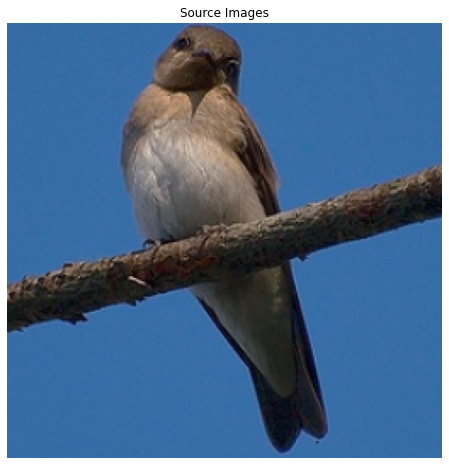

In [7]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Source Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=False),
                        (1, 2, 0)))

In [21]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    print(inp.size())
    inp = inp.detach().cpu().numpy().transpose((1, 2, 0))
    # mean = np.array([0.5, 0.5, 0.5])
    # std = np.array([0.5, 0.5, 0.5])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(8, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [22]:
#Mapping Network consisting of 8 linear layers
class MappingNetwork(nn.Module):
    def __init__(self, features=512):
        super().__init__()

        self.net = nn.Sequential(
            EqualizedWeightsLinearLayer(features, features),
            nn.LeakyReLU(0.2, False),

            EqualizedWeightsLinearLayer(features, features),
            nn.LeakyReLU(0.2, False)
        )
    def forward(self, z):
        z = F.normalize(z, dim=1)
        return self.net(z)
    
# Equalizes weights    
class EqualizedWeight(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.constant = 1 / math.sqrt(np.prod(shape[1:]))
        self.weight = nn.Parameter(torch.randn(shape))

    def forward(self):
        return self.weight * self.constant

# Creates a linear layer of equalized weights
class EqualizedWeightsLinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=0):
        super().__init__()

        features = [out_features, in_features]
        self.weight = EqualizedWeight(features)
        self.bias = nn.Parameter(torch.ones(out_features) * bias)
    
    def forward(self, x):
        return F.linear(x, self.weight(), self.bias)

In [23]:

class UpsampleBlock(nn.Module):
    '''
    Block that upsamples image in the Synthesis Network
    ie: 4x4 -> 8x8

    Test: Done
    '''
    def __init__(self):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        # Convert a blurring kernel to a tensor and normalize it and save it
        self.kernel = nn.Parameter(torch.tensor([[[[1, 2, 1],[2, 4, 2],[1, 2, 1]]]], dtype=torch.float).cuda(), requires_grad=False)
        self.kernel /= self.kernel.sum()
        self.pad = nn.ReflectionPad2d(1)
        self.conv2d = F.conv2d

    def forward(self, x):
        # Get shape of input feature map and reshape input
        b, c, h, w = x.shape
        x = self.upsample(x)
        x = x.view(-1, 1, h, w)

        # Add padding layer
        x = self.pad(x)

        # Blur input with kernel
        x = self.conv2d(x, self.kernel)

        return x.view(b, c, h * 2, w * 2)

class ConvModDeMod(nn.Module):
    '''
    Normal convolution BUT: weights are modulated (scaled) by the style vector
    and then de-modulated (formula from the paper)
    '''
    def __init__(self, in_features, out_features, kernel_size, demodulate=True):
        super().__init__()
        self.demodulate = demodulate
        self.out_features = out_features

        self.padding = (kernel_size - 1) // 2

        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])

        self.eps = 1e-2

    def forward(self, x, style_vector):
        b, c, h, w = x.shape
        style_vector = style_vector[:, None , :, None, None]

        weights = self.weight()[None, :, :, :, :]
        # print(weights.shape, style_vector.shape)

        # Modulation step
        weights = weights * style_vector

        if self.demodulate:
            sigma_inv = torch.rsqrt((weights ** 2).sum(dim=(2, 3, 4), keepdim=True) + self.eps)
            weights = weights * sigma_inv

        # Prep the inputs and weight for convolution
        x = x.reshape(1, -1, h, w)
        _, _, *ws = weights.shape

        weights = weights.reshape(b * self.out_features, *ws)

        x = F.conv2d(x, weights, padding=self.padding, groups=b)

        # Reshape to proper sizes
        x = x.reshape(-1, self.out_features, h, w)

        return x

class WToRGB(nn.Module):
    '''
    Converts a latent vector to RGB image
    '''

    def __init__(self, w_size, features):
        super().__init__()

        self.to_style = nn.Linear(w_size, features)
        self.conv = ConvModDeMod(features, 3, 1, False)
        self.bias = nn.Parameter(torch.zeros(3) + 1e-3)
        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x, w):
        style_vector = self.to_style(w)
        x = self.conv(x, style_vector)

        return self.activation(x + self.bias[None, :, None, None])


class StyleBlock(nn.Module):
    '''
    Takes a w vector, performs an affine transformation (linear layer), to get style vector.
    Modulates the convolution weights using this style vector and then returns it.
    '''
    def __init__(self, w_size, in_features, out_features):
        super().__init__()

        # This is the affine transformation
        self.to_style = nn.Linear(w_size, in_features) # Replace with EqualizedLinear layer
        self.conv = ConvModDeMod(in_features, out_features, 3)
        self.scale_noise = nn.Parameter(torch.zeros(1), requires_grad=False)
        self.bias = nn.Parameter(torch.zeros(out_features))

        self.activation = nn.LeakyReLU(0.2, False)

    def forward(self, x, w, noise):
        s = self.to_style(w)
        x = self.conv(x, s)

        if noise is not None:
            x = x + self.scale_noise[None, :, None, None] * noise
        x = self.activation(x + self.bias[None, :, None, None])

        return x
    
class SynthesisBlock(nn.Module):
    def __init__(self, w_size, in_features, out_features):
        super().__init__()

        self.style_block1 = StyleBlock(w_size, in_features, out_features)

        self.style_block2 = StyleBlock(w_size, out_features, out_features)

        self.to_rgb = WToRGB(w_size, out_features)

    def forward(self, x, ws, noise):
        # print("3: ", ws.shape)
        x = self.style_block1(x, ws[:, 0], noise[0])
        x = self.style_block2(x, ws[:, 1], noise[1])

        return x, self.to_rgb(x, ws[:, 2])

        
class SynthesisNetwork(nn.Module):
    def __init__(self, batch_size=1, w_size=512):
        super().__init__()

        self.sizes = [4, 8, 16, 32, 64, 128, 256]
        self.features = [1024 * 4, 512, 512, 512, 256, 128, 64]
        self.features = [x // 8 for x in self.features] # Reducing number of features to fit on cuda

        self.init_noise = nn.Parameter(torch.randn([batch_size, w_size, 4, 4]), requires_grad=False)

        self.style_block = StyleBlock(w_size, self.features[0], self.features[0])
        self.to_rgb = WToRGB(w_size, self.features[0])

        blocks = []
        for i in range(1, len(self.features)):
            blocks.append(SynthesisBlock(w_size, self.features[i - 1], self.features[i]))

        self.blocks = nn.ModuleList(blocks)

        self.upsample = UpsampleBlock()

    def forward(self, ws, input_noise=None):
        if input_noise is None:
            input_noise = nn.Parameter(torch.randn([7, 2]), requires_grad=False)

        # Initial 4x4 Block
        x = self.style_block(self.init_noise, ws[:, 0], input_noise[0][1])
        rgb = self.to_rgb(x, ws[:, 1])

        w_idx = 1

        # Upscale image as you go (like progressive gan)
        for i in range(1, len(self.features)):
            x = self.upsample(x) 

            temp = ws[:, w_idx:w_idx + 3].clone()

            x, rgb_new = self.blocks[i - 1](x, temp, input_noise[i]) # + 3 since rgb layer is not considered in adition
            w_idx += 2 # Increment the index of ws by 2 since there are 2 convs per synthesis block

            rgb = self.upsample(rgb) + rgb_new
        

        return rgb
    
class Generator(nn.Module):
    def __init__(self, batch_size=1, w_size=512):
        super().__init__()

        self.MappingNet = MappingNetwork()
        self.mapping = None

        self.SynthesisNet = SynthesisNetwork()
        self.synthesis = None

    def forward(self, x, input_noise=None):
        self.mapping = self.MappingNet(x)

        self.synthesis = self.SynthesisNet(self.mapping, input_noise)

        return self.synthesis

torch.Size([3, 518, 2066])


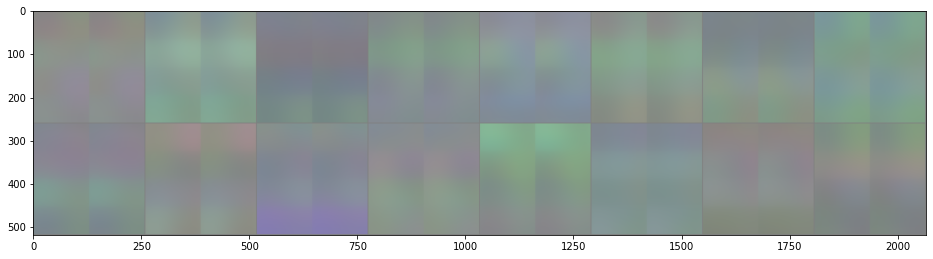

In [12]:
imshow(torchvision.utils.make_grid(out))

In [24]:
class DownsampleBlock(nn.Module):
    '''
    Block that downsamples image in the Discriminator Network
    ie: 8x8 -> 4x4
    '''
    
    def __init__(self):
        super().__init__()

        # Convert a blurring kernel to a tensor and normalize it and save it
        self.kernel = nn.Parameter(torch.tensor([[[[1, 2, 1],[2, 4, 2],[1, 2, 1]]]], dtype=torch.float).cuda(), requires_grad=False)
        self.kernel /= self.kernel.sum()
        self.kernel = nn.Parameter(self.kernel, requires_grad = False)

        self.pad = nn.ReflectionPad2d(1)

    def forward(self, x):
        # Get shape of input feature map and reshape input
        b, c, h, w = x.shape
        x = x.reshape(-1, 1, h, w)

        # Add padding with pad layer
        x = self.pad(x)

        # Blur input with kernel and reshape input
        x = F.conv2d(x, self.kernel)
        x = x.view(b, c, h, w)

        # Scale down the input and return
        return F.interpolate(x, (x.shape[2] // 2, x.shape[3] // 2), mode = 'bilinear', align_corners = False)

class eqConv2d(nn.Module):
    '''
    Creates a conv2d layer that has equalized weight between input features, output features, and kernel size
    '''
    def __init__(self, inDim, outDim, k, pad):
        super().__init__()

        # Initialize weights and multiply by a constant c
        shape = [outDim, inDim, k, k]
        c = 1 / math.sqrt(np.prod(shape[1:]))
        weight = nn.Parameter(torch.randn(shape).cuda())
        self.weight = weight * c

        # Set bias value
        self.b = nn.Parameter(torch.ones(outDim).cuda())
        self.pad = pad
  
    def forward(self, x):
        return F.conv2d(x, self.weight, bias=self.b, padding=self.pad)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.down = DownsampleBlock()
        
        # Convert an RBG image with 3 channles to a 64 channel feature map
        self.rgb = nn.Sequential(
            # Uses equalized weights and learning rate convolutional layers
            # eqConv2d(3, 64, 1, 0),
            nn.Conv2d(3, 64, 1, 1, 0),
            nn.LeakyReLU(0.2, True)
        )

        # Block that performs 2 convolutions on input
        self.layer1 = nn.Sequential(
        # Uses equalized weights and learning rate convolutional layers
        eqConv2d(64, 64, 3, 1), # conv0
        nn.LeakyReLU(0.2, False),
        eqConv2d(64, 128, 3, 1), # conv1
        nn.LeakyReLU(0.2, True)
        )

        # Residual connection to above block
        self.skip1 = nn.Sequential(
            # Uses equalized weights and learning rate convolutional layers
            DownsampleBlock(),
            eqConv2d(64, 128, 1, 0) # skip
        )

        # Block that performs 2 convolutions on input
        self.layer2 = nn.Sequential(
        # Uses equalized weights and learning rate convolutional layers
        eqConv2d(128, 128, 3, 1), # conv0
        nn.LeakyReLU(0.2, False),
        eqConv2d(128, 256, 3, 1), # conv1
        nn.LeakyReLU(0.2, True)
        )

        # Residual connection to above block
        self.skip2 = nn.Sequential(
            # Uses equalized weights and learning rate convolutional layers
            DownsampleBlock(),
            eqConv2d(128, 256, 1, 0) # skip
        )

        # Block that performs 2 convolutions on input
        self.layer3 = nn.Sequential(
        # Uses equalized weights and learning rate convolutional layers
        eqConv2d(256, 256, 3, 1), # conv0
        nn.LeakyReLU(0.2, False),
        eqConv2d(256, 512, 3, 1), # conv1
        nn.LeakyReLU(0.2, True)
        )

        # Residual connection to above block
        self.skip3 = nn.Sequential(
            # Uses equalized weights and learning rate convolutional layers
            DownsampleBlock(),
            eqConv2d(256, 512, 1, 0) # skip
        )

        # Block that performs 2 convolutions on input
        self.layer4 = nn.Sequential(
        # Uses equalized weights and learning rate convolutional layers
        eqConv2d(512, 512, 3, 1), # conv0
        nn.LeakyReLU(0.2, False),
        eqConv2d(512, 512, 3, 1), # conv1
        nn.LeakyReLU(0.2, True)
        )

        # Residual connection to above block
        self.skip4 = nn.Sequential(
            # Uses equalized weights and learning rate convolutional layers
            DownsampleBlock(),
            eqConv2d(512, 512, 1, 0) # skip
        )

        # Block that converts input to a single channel output (prediction)
        self.last = nn.Sequential(
            # Uses equalized weights and learning rate convolutional layer
            # Uses eqaulized weights and learning rate linear layers
            eqConv2d(513, 512, 1, 0),
            nn.Flatten(1),
            EqualizedWeightsLinearLayer(512 * 4 * 4, 512),
            EqualizedWeightsLinearLayer(512, 1)
        )
        
        
    def forward(self, x):
        # Convert RBG image to a feature map
        x = self.rgb(x)

        # Six connected layers of two 3x3 convolutions with a residual connection,
        # the residual connection is scaled before added 
        y = self.skip1(x)
        x = self.layer1(x)
        x = self.down(x)
        x = y.add_(x) * 1 / math.sqrt(2)

        y = self.skip2(x)
        x = self.layer2(x)
        x = self.down(x)
        x = y.add_(x) * 1 / math.sqrt(2)

        y = self.skip3(x)
        x = self.layer3(x)
        x = self.down(x)
        x = y.add_(x) * 1 / math.sqrt(2)

        y = self.skip4(x)
        x = self.layer4(x)
        x = self.down(x)
        x = y.add_(x) * 1 / math.sqrt(2)

        y = self.skip4(x)
        x = self.layer4(x)
        x = self.down(x)
        x = y.add_(x) * 1 / math.sqrt(2)

        y = self.skip4(x)
        x = self.layer4(x)
        x = self.down(x)
        x = y.add_(x) * 1 / math.sqrt(2)
        
        # Mini-batch Standard Deviation Layer
        # Split input into groups of 4
        group = x.view(4, -1)
        # Calculate standard deviation for each feature
        std = torch.sqrt(group.var(dim = 0) + 1e-2)
        # Get mean standard deviation
        std = std.mean().view(1, 1, 1, 1)
        b, c, h, w = x.shape
        std = std.expand(b, -1, h, w)
        # Add standard deviations to the feature map
        x = torch.cat([x, std], dim = 1)
        
        # Pass input to a 3x3 convolution, flattening layer, 2 linear layers, and return the classification score
        return self.last(x)

In [25]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

def get_augs(images, probability=0.1):
    
    device = images.device
    var_type = images.dtype

    images *= 255
    images = images.cpu().numpy().astype(np.uint8)
    images = np.transpose(images, (0, 2, 3, 1))


    seq = iaa.Sequential([
        iaa.HorizontalFlip(probability),
        iaa.Sometimes(probability, iaa.Rot90([-3, -2, -1, 1, 2, 3])),
        iaa.Sometimes(probability, iaa.TranslateX(percent=(-0.125, 0.125))),
        iaa.Sometimes(probability, iaa.Scale((1, 1.5))),
        iaa.Sometimes(probability, iaa.Rotate((-1, 1))),
        iaa.Sometimes(probability, iaa.MultiplyBrightness((0.8, 1.2))),
        iaa.Sometimes(probability, iaa.MultiplyHueAndSaturation((-4, 4))),
        iaa.Resize(256),
    ])

    images = seq.augment(images=images)

    images = np.array(images).astype(np.float16)
    images /= 255

    images = torch.from_numpy(images)
    images = images.to(device).type(var_type)
    images = images.permute((0, 3, 1, 2))

    return images

def tune_augs(probability, dtrain, target=0.6, p_inc=0.01):

    print(torch.sign(torch.mean(dtrain.sign()) - target) * p_inc)

    probability += torch.sign(torch.mean(dtrain.sign()) - target) * p_inc

    return max(0, probability)

    

In [197]:
# Testing ADA
for data in train_loader:
    print(data[0].shape)
    data[0] = data[0]

    # imshow(torchvision.utils.make_grid(data[0][:8], normalize=True))


    aug = get_augs(data[0], 0.05)
    # imshow(torchvision.utils.make_grid(aug[:8], normalize=True))


    break
print(disc_out.shape)
print(tune_augs(0, disc_out))


torch.Size([128, 3, 256, 256])


c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


torch.Size([16, 1])
tensor(-0.0100, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
0


In [26]:
def train_discriminator(gen, disc, mapping_network, inputs, latent_dim, criterion, device, features=14):
  """ Trains the discrinator of the GAN model.

      Args:
          gen: The generator of the model currently being trained
          disc: The discriminator of the model currently being trained
          map: The mapping network of the model currently being trained
          inputs: The real images found in our data set
          latent_dim: The latent dimension of our noise vector
          criterion: The loss function used for our model
          device: The device used for cuda
    """

  batchSize = inputs.size(0)

  # Get real images from data set
  real_images = inputs#.to(device)
  realLabels = torch.ones(batchSize, device = device, dtype=torch.float16)

  # Get w from mapping network 
  w = None
  # Determines whether we should implement style mixing or not
  if torch.rand(()).item() < 0:
    cross = int(torch.rand(()).item() * features)
    # Randomly samples 2 latent vectors
    z1, z2 = torch.randn(batchSize, 512).to(device), torch.randn(batchSize, 512).to(device)
    w1 = mapping_network(z1)[None, :, :].expand(cross, -1, -1)
    w2 = mapping_network(z2)[None, :, :].expand(features - cross, -1, -1)

    # Mixes the styles generated 
    w = torch.cat((w1, w2), dim=0)
  else:
    z = torch.randn(batchSize, 512).to(device)

    # Does not mix styles
    w = mapping_network(z)
    w = w[None, :, :].expand(features, -1, -1)
    

  w = torch.transpose(w, 0, 1)

  # Create fake images with generator
  fake_images = gen.forward(w, None)

  fakeLabels = torch.zeros(batchSize, device = device)

  # Get discriminator loss on real images
  discPredReal = disc.forward(real_images)
  realLoss = criterion(discPredReal.squeeze(1), realLabels) 

  # Get discriminator loss on fake images
  discPredFake = disc.forward(fake_images)
  fakeLoss = criterion(discPredFake.squeeze(1), fakeLabels) 

  # Take average of losses
  discLoss = 0.5 * (realLoss + fakeLoss) 

  return realLabels, fakeLabels, discLoss, discPredReal

def train_generator(gen, disc, mapping_network, inputs, criterion, device, features=14):
  """ Trains the generator of the GAN model.

    Args:
        gen: The generator of the model currently being trained
        disc: The discriminator of the model currently being trained
        map: The mapping network of the model currently being trained
        inputs: The fake images generated by our generator in the discriminator training
        realLabels: A tensor of ones to label the images as real
        criterion: The loss function used for our model
        device: The device used for cuda
    """ 

  batchSize = inputs.size(0)
  realLabels = torch.ones(batchSize, device = device)

  # Get w from mapping network
  w = None

  # Determines whether we should implement style mixing or not
  if torch.rand(()).item() < 0:
    cross = int(torch.rand(()).item() * features)
    # Randomly samples 2 latent vectors
    z1, z2 = torch.randn(batchSize, 512).to(device), torch.randn(batchSize, 512).to(device)
    w1 = mapping_network(z1)[None, :, :].expand(cross, -1, -1)
    w2 = mapping_network(z2)[None, :, :].expand(features - cross, -1, -1)

    # Mixes the styles generated 
    w = torch.cat((w1, w2), dim=0)
  else:
    z = torch.randn(batchSize, 512).to(device)

    # Does not mix styles
    w = mapping_network(z)
    w = w[None, :, :].expand(features, -1, -1)


  w = torch.transpose(w, 0, 1)

  # Create fake images with generator
  fake_images = gen.forward(w, None)

  # Get discriminator loss on fake images with real labels instead of fake labels
  discPredFake = disc.forward(fake_images)

  genLoss = criterion(discPredFake.squeeze(1), realLabels)


  return genLoss, discPredFake, fake_images

  
def train_network(generator, discriminator, mapping, interval, device, trainLoader, num_epochs, lrGAN = 1e-5, lrMap = 1e-5, latent_dim = 512, cuda=True):
    """ Trains the model entirely (both the generator and discriminator) and stores results.

    Args:
        gen: The generator of the model currently being trained
        disc: The discriminator of the model currently being trained
        map: The mapping network of the model currently being trained
        latent_dim: The latent dimension of our noise vector
        device: The device being used for cuda
        trainLoader: The training data for our model to access during training
        num_epochs: The number of epochs to run our model for
        lrGAN: The learning rate of our generator and discriminator
        lrMap: The learning rate of our mapping network
        interval: The iteration interval at which we print our model's loss values
    """
    
    # Set manual seed for reproducible results
    torch.manual_seed(1)

    # Criterion and optimizers
    criterion = nn.BCEWithLogitsLoss() # necessary if we use our loss function and not theirs
    gen_optimizer =  optim.Adam(generator.parameters(), lr= lrGAN, weight_decay=1e-3)
    disc_optimizer =  optim.Adam(discriminator.parameters(), lr=lrGAN, weight_decay=1e-3)
    map_optimizer = optim.Adam(mapping.parameters(), lr = lrMap, weight_decay = 1e-3)

    # Training metrics
    train_gen_loss = []
    train_disc_loss = []
    train_disc_real_acc = []
    train_disc_fake_acc = []
    newImgs = []

    inputNoise = nn.Parameter(torch.randn([7, 2]), requires_grad=False)
    inputW = mapping(torch.randn(batchSize, 512).to(device))
    inputW = inputW[None, :, :].expand(features, -1, -1)
    inputW = torch.transpose(inputW, 0, 1)

    ########## SENDING TO CUDA ############
    if cuda:
        generator = generator.to('cuda:0')
        discriminator = discriminator.to('cuda:0')
        mapping = mapping.to('cuda:0')

    start_time = time.time()

    # Train loop
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        mapping.train()
        iteration = 0
    
        for imgs, _ in trainLoader:

            if cuda:
               imgs = imgs.cuda()

            # Train Discriminator
            disc_optimizer.zero_grad()
            realLabels, fakeLabels, discLoss, discPredReal = train_discriminator(generator, discriminator, mapping, imgs, latent_dim, criterion, device)

            discLoss.backward(retain_graph=True)            
            disc_optimizer.step()
        
            # Train Generator and Mapping Network
            gen_optimizer.zero_grad()
            map_optimizer.zero_grad()
            genLoss, discPredFake, fake_images = train_generator(generator, discriminator, mapping, imgs, criterion, device)
            genLoss.backward(retain_graph=True)
            gen_optimizer.step()
            map_optimizer.step()

            # Calculate accuracy of model
            predReal = torch.where(discPredReal.detach() > 0.0, 1.0, 0.0)
            predFake = torch.where(discPredFake.detach() > 0.0, 1.0, 0.0)
            accReal = (predReal == realLabels).float().mean() * 100
            accFake = (predFake == fakeLabels).float().mean() * 100

            # Store discriminator loss and accuracies, and generator loss
            train_disc_loss.append(discLoss.item())
            # Maybe add  torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)
            train_gen_loss.append(genLoss.item())  
            # Maybe add  torch.nn.utils.clip_grad_norm_(self.generator.parameters(), max_norm=1.0)         
            train_disc_real_acc.append(accReal.item())
            train_disc_fake_acc.append(accFake.item())

            iteration += 1

            # If at iteration interval, print current results of model
            if iteration % interval == 0:
              print("Epoch: %03d/%03d | Batch %03d/%03d | Gen/Disc Loss: %.4f/%.4f"
                        % (epoch + 1, num_epochs, iteration, len(trainLoader),
                            genLoss.item(), discLoss.item()))
              
        # Store images created by generator every 100 epoch
        if epoch % 10 == 0:
          # Use constant input w vector and noise to see how our generator improves on same data
          tempImg = generator.forward(inputW, inputNoise)
          imshow(tempImg, title=None)
          
        print("Time elapsed: %.2f min" % ((time.time() - start_time) / 60))

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    return train_gen_loss, train_disc_loss, train_disc_real_acc, train_disc_fake_acc, newImgs

In [27]:
gen_net = Generator()
disc_net = Discriminator()

train_network(gen_net.SynthesisNet, disc_net, gen_net.MappingNet, 100, 'cuda:0', train_loader, 30)

tensor([[-3.2102]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-3.1839]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-3.1544]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-3.1275]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-3.0992]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-3.0704]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-3.0421]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-3.0156]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.9879]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.9601]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.9334]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.9056]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.8773]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.8498]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.8245]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-2.7974]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([

KeyboardInterrupt: 